In [128]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from scipy.stats import skewnorm

from utils import *

In [129]:
model = AutoEncoder(in_channels=1)
model.load_state_dict(torch.load('trained_models/auto_encoder.pt'))

<All keys matched successfully>

In [130]:
# Get latent variable
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)
test_data = gen.get_full_data_set(training=False)

x_test, y_test = test_data

# Convert y_train and y_test into one-hot vectors
y_test = to_one_hot(y_test)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

images, _ = iter(test_loader).next()
latent = model.encoder(images)

mean = latent.mean(dim=0)
std = (latent-mean).pow(2).mean(dim=0).sqrt()

z = torch.randn(32, 64) * std + mean

z

tensor([[ 5.4413e+00,  8.6732e-01, -6.6285e+00,  ..., -9.4797e+00,
          6.0623e+00, -6.8646e+00],
        [-4.5937e+00, -1.0338e+00,  2.2114e+00,  ..., -1.3867e+00,
          2.9685e+00,  3.9319e-01],
        [ 3.6098e+00, -2.7425e+00,  2.6741e+00,  ..., -6.8192e+00,
          5.3221e+00, -2.8137e+00],
        ...,
        [ 2.5665e+00,  6.3100e+00, -6.1690e-03,  ..., -1.4689e+00,
         -5.9356e+00,  6.3837e+00],
        [ 4.9631e+00, -2.9670e+00, -5.9179e-01,  ...,  1.2763e+00,
         -7.4206e-01, -3.6479e+00],
        [-2.8434e+00, -3.0641e+00,  3.6222e+00,  ...,  8.0249e-01,
         -2.8864e+00, -2.3608e+00]], grad_fn=<AddBackward0>)

In [131]:
model.eval()
with torch.no_grad():
    generated_image = model.decoder(z)[0]

In [132]:
generated_image.shape

torch.Size([1, 28, 28])

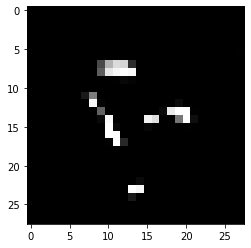

In [133]:
plt.imshow(generated_image.permute(1, 2, 0).squeeze(), cmap="gray")

In [134]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  

In [135]:
z = model.decoder[0:3](z)

c1 = model.decoder[3](z)
c1 = F.relu(c1)

c2 = model.decoder[5](c1)
c2 = F.relu(c2)

c3 = model.decoder[7](c2)
c3 = F.relu(c3)


c4 = model.decoder[9](c3)
c4 = F.relu(c4)


c1.shape, c2.shape, c3.shape, c4.shape


(torch.Size([32, 64, 4, 4]),
 torch.Size([32, 32, 7, 7]),
 torch.Size([32, 16, 14, 14]),
 torch.Size([32, 1, 28, 28]))

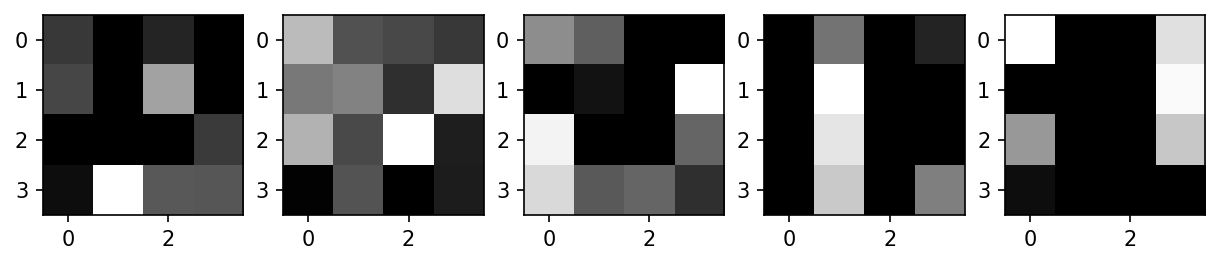

In [136]:
# Visualize som feature maps from c1
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c1[0][i], cmap='gray')
        
    plt.show()

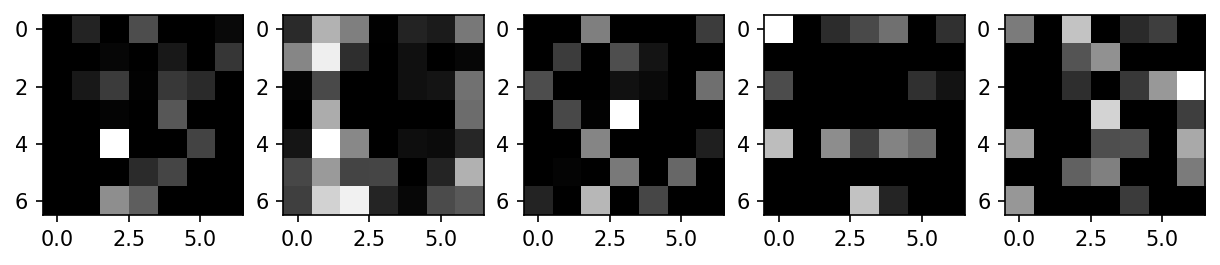

In [137]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c2[0][i], cmap='gray')
        
    plt.show()

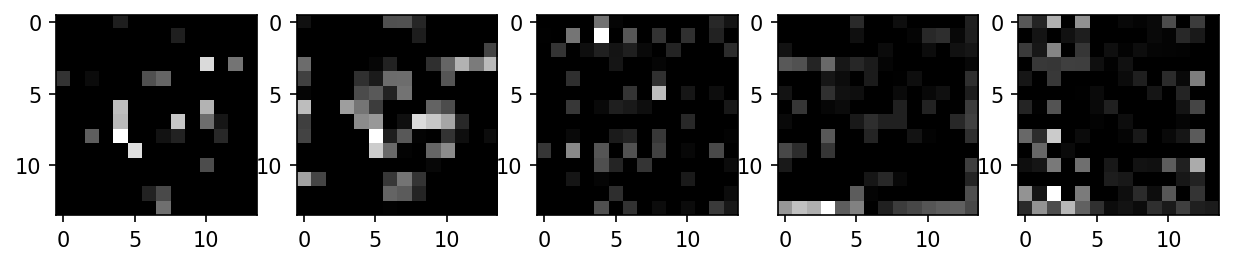

In [138]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c3[0][i], cmap='gray')
        
    plt.show()

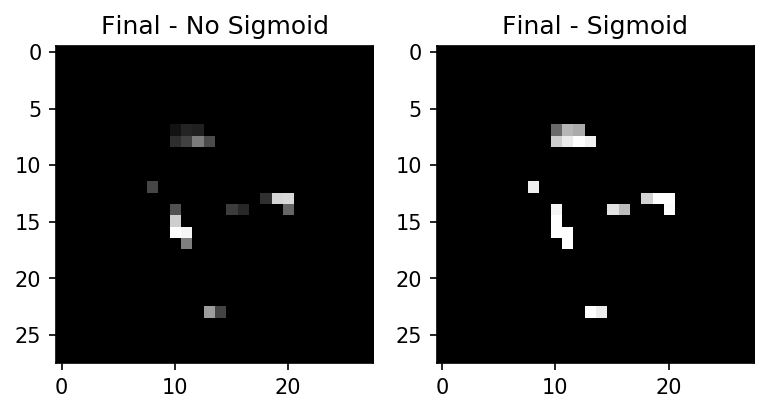

In [139]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

    # Plot each image in a separate subplot
    axs[0].imshow(c4[0].squeeze(0), cmap='gray')
    axs[0].set_title('Final - No Sigmoid')
    axs[1].imshow(F.sigmoid(c4[0].squeeze(0)), cmap='gray')
    axs[1].set_title('Final - Sigmoid')

        
    plt.show()
    